Problem: we need to train a sentiment-classifier trained on an unbalanced dataset.

Requirements: first, load the dair-ai/emotion dataset using the load_dataset function from the datasets module. This dataset is pre-split into train, validation and test sets. Fit a CountVectorizer from SKLearn to vectorize the text of each sample. Finally, train a Logistic Regression model from SKLearn using the vectorized training samples.

Using the validation set, measure the class-wise precision of the model. You will probably see that the model does not perform the same on the highly-represented class (e.g. "joy") compared to the less-represented classes (e.g. "surprise"). Tune the model to balance the model by improving the precision for every class. You may try adjusting the hyper-parameters, adjusting the tokenizer, or selecting a new model.

After you are finished with tuning the model, print its confusion matrix and compute its accuracy on the test set.

In [15]:
!pip install datasets

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [17]:
# Load the dair-ai/emotion dataset
dataset = load_dataset("dair-ai/emotion")

In [18]:
# Extract train, validation, and test splits
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

# Convert the datasets into DataFrames for easier handling
train_df = pd.DataFrame({'text': train_data['text'], 'label': train_data['label']})
val_df = pd.DataFrame({'text': val_data['text'], 'label': val_data['label']})
test_df = pd.DataFrame({'text': test_data['text'], 'label': test_data['label']})

# Initialize and fit a CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])

# Extract labels
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

In [19]:
# Use TfidfVectorizer for better handling of class imbalance and less frequent words
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5)
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])

# Extract labels
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']


In [22]:
# Use GridSearchCV to tune Logistic Regression hyperparameters
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='precision_weighted')
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [23]:
# Evaluate on the validation set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)

# Display class-wise precision
classes = val_data.features['label'].names
class_precision = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})
print(f"Validation Accuracy: {val_accuracy:.4f}\n")
print("Class-wise Precision, Recall, and F1-Score:")
print(class_precision)

# Final evaluation on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Validation Accuracy: 0.9055

Class-wise Precision, Recall, and F1-Score:
      Class  Precision    Recall  F1-Score  Support
0   sadness   0.947170  0.912727  0.929630      550
1       joy   0.957317  0.892045  0.923529      704
2      love   0.774775  0.966292  0.860000      178
3     anger   0.897527  0.923636  0.910394      275
4      fear   0.860577  0.844340  0.852381      212
5  surprise   0.752475  0.938272  0.835165       81

Test Accuracy: 0.8990
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       581
           1       0.96      0.89      0.92       695
           2       0.71      0.95      0.81       159
           3       0.88      0.91      0.90       275
           4       0.90      0.85      0.87       224
           5       0.61      0.94      0.74        66

    accuracy                           0.90      2000
   macro avg       0.84      0.91      0.86      2000
weighted avg       0.91 

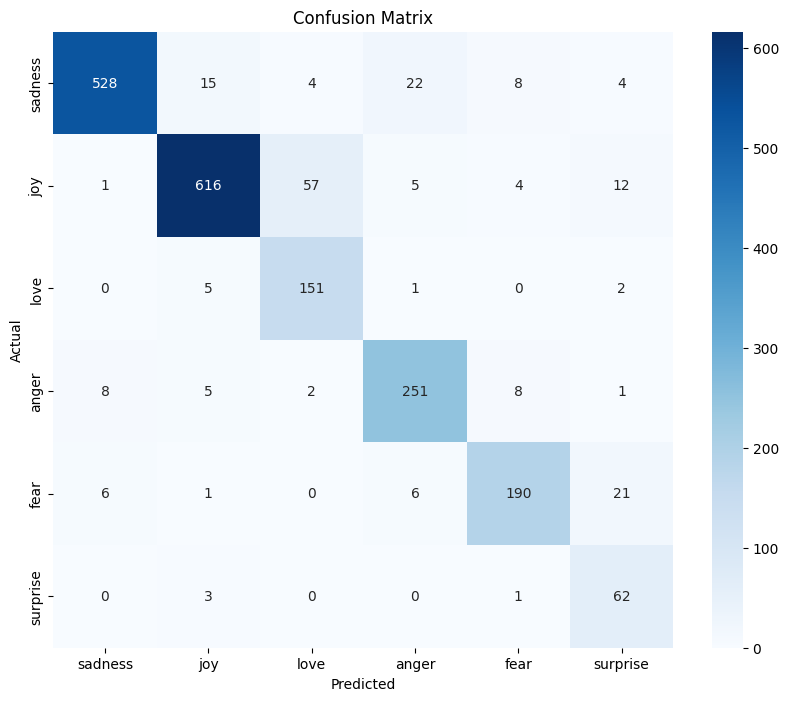

In [24]:
# Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()